# Implementing the SPT Model

Modifications: Johnny Esteves\
Author: Allen Pinjic - Created on June 6th, 2022

In [1]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pylab as plt
import pymc3 as pm
import aesara
import matplotlib.font_manager
import scipy.stats
import scipy.optimize
import math

In [3]:
%matplotlib inline

## Retrieving SPT Data

In [4]:
fname = '../data_set/sptecs_catalog_oct919.fits'

data = Table(getdata(fname))
data[:2]

SPT_ID,RA,DEC,FIELD,XI,THETA_CORE,REDSHIFT,REDSHIFT_UNC,SPECZ,REDSHIFT_SOURCE,RM_PROB,CL_NOTES,M500,M500_UERR,M500_LERR,LAMBDA_CHISQ,LAMBDA_CHISQ_E,RADIO_CONTAM,STRONG_LENS,IMAGE_SOURCE,SPECZ_REF,STRONG_LENS_REF,PHOTOMETRIC_ZREF
str16,float64,float64,str11,float32,float32,float32,float32,int16,float32,float32,str50,float32,float32,float32,float32,float32,float32,float32,float32,str38,str19,str29
SPT-CLJ0000-2518,0.072338357,-25.303935,ra1hdec-25,5.073545,1.5,0.0,0.0,0,0.0,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,,,
SPT-CLJ0005-3751,1.4383179,-37.854369,ra1hdec-35,6.336327,0.75,0.48295808,0.0072415886,0,4.0,0.00061007956,-,5.419,0.887,0.887,86.40839,4.7352147,0.0,1.0,3.0,,,


In [5]:
sz_signal = np.array(data['XI'])
lambda_chisq = np.array(data['LAMBDA_CHISQ'])
lambda_chisqE = np.array(data['LAMBDA_CHISQ_E'])
redshift = np.array(data['REDSHIFT'])

(array([17., 64., 75., 45., 27., 19., 16., 13.,  7.,  7.]),
 array([14.481873, 14.530734, 14.579596, 14.628457, 14.677319, 14.726179,
        14.775041, 14.823902, 14.872764, 14.921625, 14.970487],
       dtype=float32),
 <BarContainer object of 10 artists>)

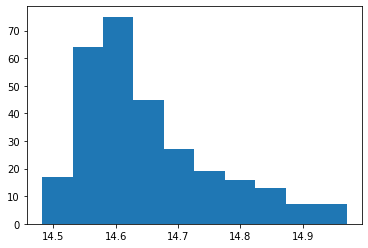

In [6]:
plt.hist(np.log10(data['M500'][lambda_chisq>20]*1e14))

## Define Model

In [7]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function
cosmology.setCosmology('WMAP9')

def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')
halo_mass_function = np.vectorize(_halo_mass_function)

def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

In [8]:
# LogNormal models
# see https://en.wikipedia.org/wiki/Log-normal_distribution
M0 = 3e14
Ez0 = E(0)
def ln_lbd_given_M(theta_lambda,M,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0))

def ln_zeta_given_M(theta_sze,M,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0))

def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)

In [9]:
from scipy.integrate import simps

# given: mvec, lbdvec and zetavec

def log_likelihood(theta, z, y, yerr, eps=1e-9):
    # defining variables
    lbd_hat, chisi = y[0], y[1]
    lbd_error = yerr
    nsize = len(lbd_hat)
    
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]

    # setting grid for integration
    mm, zz = np.meshgrid(mvec, z)

    # calling predictions; 
    ln_lbd_pred = (ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda],mm,zz)).T
    ln_zeta_pred= (ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze],mm,zz)).T

    halo_mass_func = (halo_mass_function2(z))
        
    # integrating over zeta, lambda
    prob = marginalize_over_lbd_zeta(lbd_hat, lbd_error, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                                     scatter_lambda, scatter_sze, rho)
    log_prob = np.log(prob)
    return np.sum(log_prob)

def marginalize_over_lbd_zeta(lbd_hat, lbd_err, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                              scatter_lambda, scatter_zeta, rho):
    # integrating over zeta, lambda
    nsize = len(lbd_hat)
    # integrating over zeta, lambda
    res_zeta = np.full((zetavec.size, nsize),np.nan,dtype=float)
    res_lbd = np.full((lbdvec.size, nsize),np.nan,dtype=float)

    for j,li in enumerate(lbdvec):
        for i,zi in enumerate(zetavec):
            res_zeta[i] = compute_dn_dlbd_dzeta(li, zi, lbd_hat, lbd_err, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                                              scatter_lambda, scatter_sze, rho)
        # integrate over zeta for a given lambda
        res_lbd[j] = np.trapz(res_zeta, axis=0)
    # integrate over lambda
    prob = np.trapz(res_lbd, x=lbdvec, axis=0)
    # normalize over all posibilities
    prob = prob/np.sum(prob)
    return prob

## likelihood including the errors
def compute_dn_dlbd_dzeta(lbd, zeta, lbd_hat, lbd_err, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                          scatter_lambda, scatter_zeta, rho, eps=1e-9):
    # converting std to normal distribution
    s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
    s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)

    # avoid error messages
    rho_inv = (1-rho**2)
    rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)

    # defining standirized variables
    lbd_std = (lbd - np.exp(ln_lbd_pred))/s_lambda
    zeta_std = (zeta - np.exp(ln_zeta_pred))/s_zeta

    # lbd_likelihood
    lp_lbd  = -rho_inv*lbd_std**2/2 -((lbd-lbd_hat)/lbd_err)**2/2.

    # zeta likelihood
    lp_zeta = -rho_inv*zeta_std**2/2 -(chisi-np.sqrt(zeta**2+3))**2/2.

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std

    lp_total_m = lp_lbd+lp_zeta+lp_corr
    p_total_m = np.exp(lp_total_m)*halo_mass_func
    #p_total_m = np.where(p_total_m<eps, 0., p_total_m)
    
    # integrate over M
    p_total = np.trapz(p_total_m, x=mvec, axis=0)
    
    return np.where(p_total>1e16, 0., p_total/M0)

### Debugging

In [10]:
# getting some observational data to debug the code
Np = 10
ix = np.where(lambda_chisq>30)[0][:Np] # take 10 points

z = redshift[ix]
chisi = sz_signal[ix]
lbd_hat = lambda_chisq[ix]
lbd_err = lambda_chisqE[ix]

In [11]:
# test function 
# debuging here
eps  =1e-9
lbd  = lbd_hat[0]
zeta = chisi[0]

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

In [203]:
50*20*75

75000

In [268]:
# set up integration vectors
mvec = np.logspace(13.8, 15.25, 50)
# lbdvec = np.linspace(15., 1.5*np.max(lambda_chisq), 50)
# zetavec = np.linspace(3, 1.3*np.max(sz_signal), 20)

lbdvec = np.logspace(np.log10(15.), np.log10(1.5*np.max(lambda_chisq)), 75)
zetavec = np.logspace(np.log10(3), np.log10(1.3*np.max(sz_signal)), 20)

print('Vector size')
print(mvec.size)
print(lbdvec.size)
print(zetavec.size)

Vector size
50
75
20


In [269]:
zvec = np.linspace(0., 1.3, 100)
zzv, mm = np.meshgrid(zvec, mvec)
from scipy import interpolate
halo_mass_function2 = interpolate.interp1d(zvec, halo_mass_function(mm, zzv), kind='cubic')

In [270]:
# unfolding theta
A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
A_sze, B_sze, C_sze, scatter_sze = theta[:4]
rho = theta[-1]

# setting grid for integration
mm, zz = np.meshgrid(mvec, z)

# calling predictions; 
ln_lbd_pred = (ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda],mm,zz)).T
ln_zeta_pred= (ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze],mm,zz)).T

halo_mass_func = (halo_mass_function(mm, zz)).T

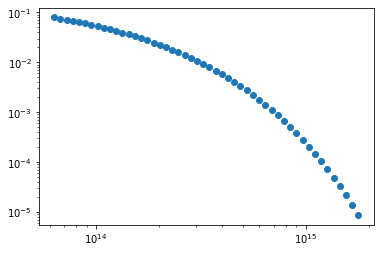

In [271]:
plt.loglog()
plt.scatter(mvec, halo_mass_func[:,0])

In [272]:
# the linear relation lnLbd and lnZeta are logNormal
# the scatter of a logNormal is different from a normal distribution
# see the std from https://en.wikipedia.org/wiki/Log-normal_distribution
def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)

In [273]:
# converting std to normal distribution
s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)

# avoid error messages
rho_inv = (1-rho**2)
rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)

# defining standirized variables
lbd_std = (lbd - np.exp(ln_lbd_pred))/s_lambda
zeta_std = (zeta - np.exp(ln_zeta_pred))/s_zeta

# lbd_likelihood
lp_lbd  = -rho_inv*lbd_std**2/2 -((lbd-lbd_hat)/lbd_err)**2/2.

# zeta likelihood
lp_zeta = -rho_inv*zeta_std**2/2 -(chisi-np.sqrt(zeta**2+3))**2/2.

# corr likelihod
lp_corr = rho*rho_inv*lbd_std*zeta_std

lp_total_m = lp_lbd+lp_zeta+lp_corr
p_total_m = np.exp(lp_total_m)*halo_mass_func

# integrate over M
p_total = np.trapz(p_total_m, x=mvec/M0, axis=0)

In [274]:
p_total[0]

0.0023262040540313286

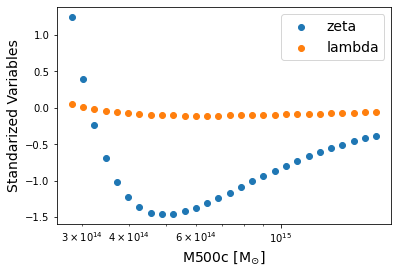

In [275]:
# plt.loglog()
w, = np.where(np.abs(zeta_std[:,0])<2.)
plt.scatter(mvec[w],zeta_std[:,0][w],label='zeta')
plt.scatter(mvec[w],lbd_std[:,0][w],label='lambda')
plt.xscale('log')
plt.xlabel(r'M500c [M$_{\odot}$]',fontsize=14)
plt.ylabel('Standarized Variables',fontsize=14)
plt.legend(fontsize=14)

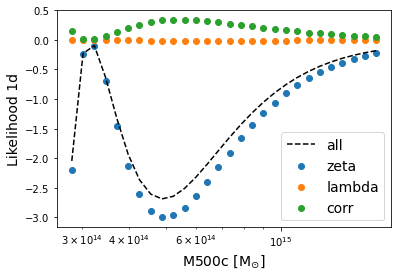

In [276]:
# plt.loglog()
plt.scatter(mvec[w],lp_zeta[:,0][w],label='zeta')
plt.scatter(mvec[w],lp_lbd[:,0][w],label='lambda')
plt.scatter(mvec[w],lp_corr[:,0][w],label='corr')
plt.plot(mvec[w],lp_total_m[:,0][w],label='all',color='k',ls='--')
plt.xscale('log')
plt.xlabel(r'M500c [M$_{\odot}$]',fontsize=14)
plt.ylabel('Likelihood 1d',fontsize=14)
plt.legend(fontsize=14)

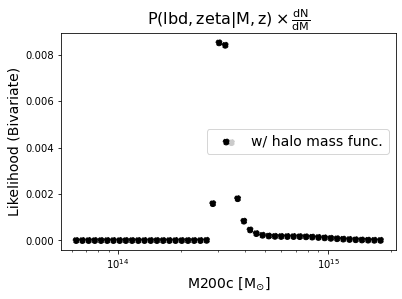

In [277]:
# plt.loglog()
plt.scatter(mvec,p_total_m[:,0],label='w/ halo mass func.',color='k',ls='--')
plt.xscale('log')
plt.xlabel(r'M200c [M$_{\odot}$]',fontsize=14)
plt.ylabel('Likelihood (Bivariate)',fontsize=14)
plt.title(r'$\rm P(lbd, zeta| M, z) \times \frac{dN}{dM}$', fontsize=16)
plt.legend(fontsize=14)

In [278]:
p = compute_dn_dlbd_dzeta(lbd_hat[0], zeta, lbd_hat, lbd_err, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                          scatter_lambda, scatter_sze, rho)
p

array([2.32620405e-03, 9.72812746e-07, 2.12568224e-05, 3.60535907e-05,
       4.05347051e-03, 1.32425461e-04, 3.04978496e-10, 2.53097952e-06,
       1.14367517e-06, 1.24735407e-06, 8.35626842e-08, 1.45897513e-32,
       2.51799752e-09, 3.91943699e-18, 3.47038436e-04, 7.41705828e-23,
       1.07395649e-30, 4.34050185e-24, 6.53322578e-09, 5.36343974e-36,
       8.24761069e-04, 2.50361868e-29, 5.35486931e-06, 1.01938287e-03,
       1.56880743e-27, 5.00044157e-18, 1.35378731e-25, 1.79328400e-12,
       1.99062876e-21, 2.33590921e-52, 3.22698781e-28, 6.32915191e-04,
       1.08351155e-65, 6.41332076e-14, 7.92037464e-04, 4.13027393e-05,
       4.13455764e-13, 1.53569263e-10, 4.59183518e-08, 1.40829959e-03,
       4.69376593e-08, 2.01200822e-05, 1.75123546e-13, 4.26578151e-04,
       1.58819723e-03, 2.10723661e-13, 9.74759865e-21, 5.43658759e-05,
       4.58895543e-14, 1.36172359e-21, 8.25005413e-04, 7.10228762e-28,
       1.76047981e-10, 3.29400810e-16, 5.85325730e-19, 4.09066893e-04,
      

In [279]:
# res_zeta/1e-12

In [280]:
# integrating over zeta, lambda
nsize = len(lbd_hat)
# integrating over zeta, lambda
res_zeta = np.full((zetavec.size, nsize),np.nan,dtype=float)
res_lbd = np.full((lbdvec.size, nsize),np.nan,dtype=float)

for j,li in enumerate(lbdvec):
    for i,zi in enumerate(zetavec):
        res_zeta[i] = compute_dn_dlbd_dzeta(li, zi, lbd_hat, lbd_err, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                                          scatter_lambda, scatter_sze, rho)
    # integrate over zeta for a given lambda
    res_lbd[j] = np.trapz(res_zeta, axis=0)
# integrate over lambda
prob = np.trapz(res_lbd, x=lbdvec, axis=0)
# normalize over all posibilities
prob = prob/np.sum(prob)
prob

array([7.59689755e-03, 2.11418787e-02, 4.37953663e-03, 4.08183884e-03,
       7.53039092e-02, 2.53600284e-03, 1.23486023e-02, 1.08621276e-02,
       7.39601053e-02, 3.04931915e-03, 6.77561857e-03, 9.56202612e-03,
       2.30701840e-02, 7.29729122e-03, 2.15383799e-02, 6.64439513e-03,
       9.06602483e-03, 6.90177125e-03, 1.30098502e-03, 4.12972467e-03,
       2.73122590e-02, 1.88232228e-03, 1.02360376e-03, 6.68296907e-03,
       5.23452047e-03, 3.68791856e-03, 2.07313022e-03, 2.24049499e-03,
       1.19036585e-03, 6.67591158e-03, 9.28063049e-03, 1.29991798e-02,
       4.19814516e-03, 1.81270602e-03, 6.62710794e-03, 5.11658607e-03,
       7.30993005e-03, 6.28139281e-04, 1.79808476e-02, 4.43969833e-02,
       1.88434862e-03, 2.64212613e-02, 2.70445796e-03, 1.69581921e-02,
       7.55350926e-02, 1.27348361e-03, 1.68588151e-03, 4.95255991e-03,
       2.99496672e-03, 1.04071465e-02, 3.74392501e-03, 8.56141372e-03,
       3.63974652e-03, 3.55728511e-03, 5.60430289e-03, 7.76812570e-03,
      

In [281]:
marginalize_over_lbd_zeta(lbd_hat, lbd_err, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                              scatter_lambda, scatter_sze, rho)

array([7.59689755e-03, 2.11418787e-02, 4.37953663e-03, 4.08183884e-03,
       7.53039092e-02, 2.53600284e-03, 1.23486023e-02, 1.08621276e-02,
       7.39601053e-02, 3.04931915e-03, 6.77561857e-03, 9.56202612e-03,
       2.30701840e-02, 7.29729122e-03, 2.15383799e-02, 6.64439513e-03,
       9.06602483e-03, 6.90177125e-03, 1.30098502e-03, 4.12972467e-03,
       2.73122590e-02, 1.88232228e-03, 1.02360376e-03, 6.68296907e-03,
       5.23452047e-03, 3.68791856e-03, 2.07313022e-03, 2.24049499e-03,
       1.19036585e-03, 6.67591158e-03, 9.28063049e-03, 1.29991798e-02,
       4.19814516e-03, 1.81270602e-03, 6.62710794e-03, 5.11658607e-03,
       7.30993005e-03, 6.28139281e-04, 1.79808476e-02, 4.43969833e-02,
       1.88434862e-03, 2.64212613e-02, 2.70445796e-03, 1.69581921e-02,
       7.55350926e-02, 1.27348361e-03, 1.68588151e-03, 4.95255991e-03,
       2.99496672e-03, 1.04071465e-02, 3.74392501e-03, 8.56141372e-03,
       3.63974652e-03, 3.55728511e-03, 5.60430289e-03, 7.76812570e-03,
      

In [282]:
y = np.vstack([lbd_hat,chisi])
yerr = lbd_err

In [283]:
lnP = log_likelihood(theta, z, y, yerr, eps=1e-9)
lnP

# it takes 2s one evalution on array of 10 clusters

-520.519121159779

## A meshgrid array of 3D

In [284]:
from scipy.integrate import simps

# given: mvec, lbdvec and zetavec
mm, zz, ll = np.meshgrid(mvec, zetavec, lbdvec, indexing='ij')
def log_likelihood_vec(theta, z, y, yerr, eps=1e-9):
    # defining variables
    lbd_hat, chisi = y[0], y[1]
    lbd_err = yerr
    probs = []
    for lbd_hat_i, lbd_err_i, chisi_i, z_i in zip(lbd_hat, lbd_err, chisi, z):
        probs.append(_log_likelihood(theta, lbd_hat_i, lbd_err_i, chisi_i, z_i))    
    p = np.array(probs)/np.sum(probs)
    return np.sum(np.log(p))

def _log_likelihood(theta, lbd_hat_i, lbd_err_i, chisi_i, z_i):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mvec, z_i)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mvec, z_i)
    halo_mass_func = halo_mass_function2(z_i)

    hmf = np.tile(halo_mass_func, (len(lbdvec), len(zetavec), 1)).T
    ln_lbd_pred = np.tile(ln_lbd_pred, (len(lbdvec), len(zetavec), 1)).T
    ln_zeta_pred = np.tile(ln_zeta_pred, (len(lbdvec), len(zetavec), 1)).T
    
    # compute dn_dlbd_dzeta_integrand
    p_total_m = compute_dn_dlbd_dzeta_vec(lbd_hat_i, lbd_err_i, chisi_i,
                                          scatter_lambda, scatter_sze, rho,
                                          ln_lbd_pred, ln_zeta_pred, hmf)
    # integrate over M
    p_lbd_zeta = np.trapz(p_total_m, x=mvec, axis=0)

    # integrate over zeta
    p_lbd = np.trapz(p_lbd_zeta, x=zetavec, axis=0)

    # integrate over lambda
    p = np.trapz(p_lbd, x=lbdvec, axis=0)
    return p#np.log(p)

def compute_dn_dlbd_dzeta_vec(lbd_hat_i, lbd_err_i, chisi_i,
                              scatter_lambda, scatter_sze, rho,
                              ln_lbd_pred, ln_zeta_pred, hmf):
    # converting std to normal distribution
    s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
    s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)

    # avoid error messages
    rho_inv = (1-rho**2)
    rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)

    # defining standirized variables
    lbd_std = (ll - np.exp(ln_lbd_pred))/s_lambda
    zeta_std = (zz - np.exp(ln_zeta_pred))/s_zeta

    # lbd_likelihood
    lp_lbd  = -rho_inv*lbd_std**2/2 -((ll-lbd_hat_i)/lbd_err_i)**2/2.

    # zeta likelihood
    lp_zeta = -rho_inv*zeta_std**2/2 -(chisi_i-np.sqrt(zz**2+3))**2/2.

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std

    lp_total_m = lp_lbd+lp_zeta+lp_corr
    p_total_m = np.exp(lp_total_m)*hmf
    return p_total_m

In [285]:
# for a given cluster, i.e. a vector (lbd_hat_i, chisi_i, z_i)

lbd_hat_i = lambda_chisq[w[0]]
lbd_err_i = lambda_chisqE[w[0]]
chisi_i = sz_signal[w[0]]
z_i = redshift[w[0]]
print(lbd_hat_i)
print(chisi_i)

100.36669
6.0546207


In [286]:
mm, zz, ll = np.meshgrid(mvec, zetavec, lbdvec, indexing='ij')
print(mm.shape)
print(mm[:,0,0].size)

(50, 20, 75)
50


In [287]:
# calling predictions;
ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mvec, z_i)
ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mvec, z_i)
halo_mass_func = halo_mass_function(mvec, z_i)

hmf = np.tile(halo_mass_func, (len(lbdvec), len(zetavec), 1)).T
ln_lbd_pred = np.tile(ln_lbd_pred, (len(lbdvec), len(zetavec), 1)).T
ln_zeta_pred = np.tile(ln_zeta_pred, (len(lbdvec), len(zetavec), 1)).T
print(hmf.shape)

(50, 20, 75)


In [288]:
# converting std to normal distribution
s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)

# avoid error messages
rho_inv = (1-rho**2)
rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)

# # defining standirized variables
lbd_std = (ll - np.exp(ln_lbd_pred))/s_lambda
zeta_std = (zz - np.exp(ln_zeta_pred))/s_zeta

# lbd_likelihood
lp_lbd  = -rho_inv*lbd_std**2/2 -((ll-lbd_hat_i)/lbd_err_i)**2/2.

# zeta likelihood
lp_zeta = -rho_inv*zeta_std**2/2 -(chisi_i-np.sqrt(zz**2+3))**2/2.

# corr likelihod
lp_corr = rho*rho_inv*lbd_std*zeta_std

lp_total_m = lp_lbd+lp_zeta+lp_corr
p_total_m = np.exp(lp_total_m)*hmf#/M0
#p_total_m = np.where(p_total_m<eps, 0., p_total_m)

# integrate over M
p_lbd_zeta = simps(p_total_m, x=mvec, axis=0)

# integrate over zeta
p_lbd = simps(p_lbd_zeta, x=zetavec, axis=0)

# integrate over zeta
p = simps(p_lbd, x=lbdvec, axis=0)

print(ll.shape)
print(ln_lbd_pred.shape)
print(p_lbd.shape)
print(p)

(50, 20, 75)
(50, 20, 75)
(75,)
57937604350102.03


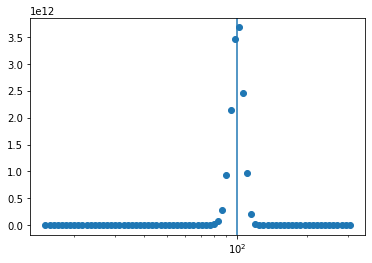

In [289]:
plt.scatter(lbdvec,p_lbd)
plt.axvline(lbd_hat_i)
plt.xscale('log')

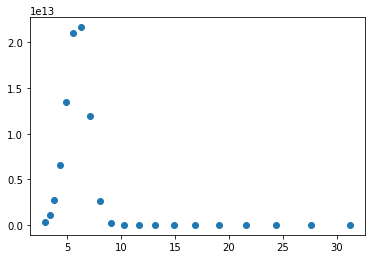

In [290]:
plt.scatter(zetavec,simps(p_lbd_zeta, x=lbdvec, axis=1))

Text(0, 0.5, 'Likelihood 1d')

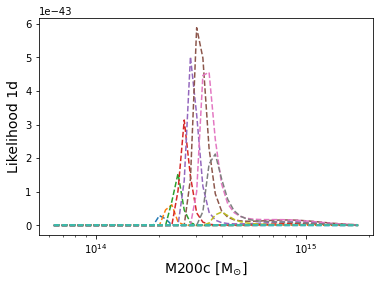

In [291]:
# plt.loglog()
for i,zi in enumerate(zetavec):
    plt.plot(mvec,p_total_m[:,i,3],ls='--',label='zeta = %.1f'%zi)
plt.xscale('log')
plt.xlabel(r'M200c [M$_{\odot}$]',fontsize=14)
plt.ylabel('Likelihood 1d',fontsize=14)
# plt.legend(fontsize=14)

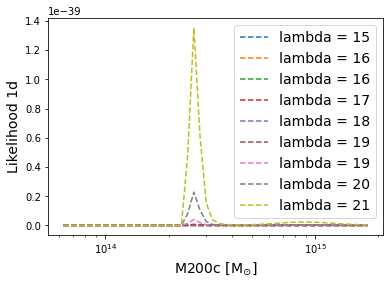

In [292]:
# plt.loglog()
for i,li in enumerate(lbdvec[1:10]):
    #plt.scatter(mvec,lp_zeta[:,i,0],label='zeta')
    # plt.scatter(mvec,lp_lbd[:,0,0],label='lambda')
    # plt.scatter(mvec[w],lp_corr[:,0][w],label='corr')
    plt.plot(mvec,p_total_m[:,3,i],ls='--',label='lambda = %i'%li)
plt.xscale('log')
plt.xlabel(r'M200c [M$_{\odot}$]',fontsize=14)
plt.ylabel('Likelihood 1d',fontsize=14)
plt.legend(fontsize=14)

In [293]:
lnP = log_likelihood(theta, z, y, yerr, eps=1e-9)
lnP

-520.519121159779

In [294]:
log_likelihood_vec(theta, z, y, yerr, eps=1e-9)

-522.2917388596242

In [295]:
## testing number of points
Np = 100
ix = np.where(lambda_chisq>30)[0][:Np] # take 10 points

z = redshift[ix]
chisi = sz_signal[ix]
lbd_hat = lambda_chisq[ix]
lbd_err = lambda_chisqE[ix]

y = np.vstack([lbd_hat,chisi])
yerr = lbd_err

In [296]:
lnP = log_likelihood(theta, z, y, yerr, eps=1e-9)
lnP
# 870ms

-520.519121159779

In [297]:
log_likelihood_vec(theta, z, y, yerr, eps=1e-9)
# 950ms

-522.2917388596242

In [201]:
# set up integration vectors
lbdvec = np.linspace(30., 1.5*np.max(lambda_chisq), 50)
zetavec = np.linspace(1., 1.3*np.max(sz_signal), 100)
mm, zz, ll = np.meshgrid(mvec, zetavec, lbdvec, indexing='ij')

print('Vector size')
print(mvec.size)
print(lbdvec.size)
print(zetavec.size)

Vector size
75
50
100


In [45]:
mvec = np.logspace(13.0, 15.2, 100)
zvec = np.linspace(0., 1.3, 100)
zzv, mm = np.meshgrid(zvec, mvec)
from scipy import interpolate
halo_mass_function2 = interpolate.interp1d(zvec, halo_mass_function(mm, zzv), kind='cubic')

In [46]:
lnP = log_likelihood(theta, z, y, yerr, eps=1e-9)
lnP
# 10s for 100 points

-521.9624681754602

In [47]:
log_likelihood_vec(theta, z, y, yerr, eps=1e-9)

-521.9624692757492